In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#STEP 1: DATA PREPROCESSING

##Reshape and normalize

In [9]:
import pickle
import numpy as np
import os

In [10]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [11]:
def load_cifar10_data(data_dir):
    train_data_list = []
    train_labels_list = []

    for i in range(1, 6):
      fname = os.path.join(data_dir, f'data_batch_{i}')
      batch_dict = unpickle(fname)

      data = batch_dict[b'data']
      data = data.reshape(10000,3,32,32).transpose(0, 2, 3, 1).astype("uint8")

      train_data_list.append(data)
      train_labels_list.extend(batch_dict[b'labels'])

    X_train = np.concatenate(train_data_list)
    y_train = np.array(train_labels_list)

    test_fname = os.path.join(data_dir, 'test_batch')
    test_batch_dict = unpickle(test_fname)
    test_data = test_batch_dict[b'data']
    X_test = test_data.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")
    y_test = np.array(test_batch_dict[b'labels'])
    return (X_train, y_train), (X_test, y_test)

In [ ]:
cifar10_dir = "/content/drive/MyDrive/Hung/Assignment-2/cifar10_data/cifar-10-batches-py"
(x_train, y_train), (x_test, y_test) = load_cifar10_data(cifar10_dir)

In [ ]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

print("\nFirst few labels of the training set:", y_train[:5])
print("Min/max pixel values of a training image:", x_train[0].min(), x_train[0].max())


x_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000,)

First few labels of the training set: [6 9 9 4 1]
Min/max pixel values of a training image: 0 255


In [ ]:
x_train_normalized = x_train.astype('float32')
x_test_normalized = x_test.astype('float32')

x_train_normalized /= 255.0
x_test_normalized /= 255.0

##Labeling

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
class Cifar10CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy.ndarray): NumPy array containing image data (N, H, W, C).
            labels (numpy.ndarray): NumPy array containing labels.
            transform (callable, optional): Optional transformation to be applied to a sample.
        """
        self.data = data
        self.labels = torch.from_numpy(labels).long()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image) # convert to tensor CHW

        return image, label

In [ ]:
cifar10_mean = [0.4914, 0.4822, 0.4465]
cifar10_std = [0.2470, 0.2435, 0.2616]

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4, padding_mode = 'reflect'),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random')
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

train_dataset = Cifar10CustomDataset(data=x_train, labels=y_train, transform=transform_train)
test_dataset = Cifar10CustomDataset(data=x_test, labels=y_test, transform=transform_test)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("Image batch shape from train_loader:", images.shape)
print("Label batch shape from train_loader:", labels.shape)
print("Label data type:", labels.dtype)
print("Min/max value of an image in the batch:", images[0].min().item(), images[0].max().item())

Image batch shape from train_loader: torch.Size([64, 3, 32, 32])
Label batch shape from train_loader: torch.Size([64])
Label data type: torch.int64
Min/max value of an image in the batch: -2.2075693607330322 2.989363193511963


## Create Validation Set

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
x_train_new, x_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

In [ ]:
print("Original training set size (x_train):", x_train.shape)
print("New training set size (x_train_new):", x_train_new.shape)
print("Validation set size (x_val):", x_val.shape)
print("New training labels size (y_train_new):", y_train_new.shape)
print("Validation labels size (y_val):", y_val.shape)


Original training set size (x_train): (50000, 32, 32, 3)
New training set size (x_train_new): (45000, 32, 32, 3)
Validation set size (x_val): (5000, 32, 32, 3)
New training labels size (y_train_new): (45000,)
Validation labels size (y_val): (5000,)


In [ ]:
train_dataset = Cifar10CustomDataset(data=x_train_new, labels=y_train_new, transform=transform_train)
val_dataset = Cifar10CustomDataset(data=x_val, labels=y_val, transform=transform_val_test)
test_dataset = Cifar10CustomDataset(data=x_test, labels=y_test, transform=transform_val_test)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# Check train_loader
train_images, train_labels_batch = next(iter(train_loader))
print("Image batch shape from new train_loader:", train_images.shape)

# Check val_loader
val_images, val_labels_batch = next(iter(val_loader))
print("Image batch shape from val_loader:", val_images.shape)

# Check test_loader
test_images, test_labels_batch = next(iter(test_loader))
print("Image batch shape from test_loader:", test_images.shape)

Image batch shape from new train_loader: torch.Size([128, 3, 32, 32])
Image batch shape from val_loader: torch.Size([128, 3, 32, 32])
Image batch shape from test_loader: torch.Size([128, 3, 32, 32])


## Define Multilayer Perceptron model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

input_size = 3 * 32 * 32
hidden_size1 = 256
hidden_size2 = 512
hidden_size3 = 256
hidden_size4 = 128
num_classes = 10
dropout_p = 0.5

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes, dropout_p):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(dropout_p)

        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.bn4 = nn.BatchNorm1d(hidden_size4)
        self.dropout4 = nn.Dropout(0.2)

        self.fc_output = nn.Linear(hidden_size4, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = F.gelu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.gelu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = F.gelu(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = F.gelu(x)
        x = self.dropout4(x)

        x = self.fc_output(x)
        return x

model_mlp = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes, dropout_p)
print(model_mlp)

MLP(
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc_output): Linear(in_features=128, out_features=10, bias=True)
)


### Check model

In [ ]:
dummy_input = torch.randn(128, 3, 32, 32)
output = model_mlp(dummy_input)
print("\nShape of MLP:", output.shape)


Shape of MLP: torch.Size([128, 10])


### Define Epochs, Loss function and Optimizer

In [ ]:
import torch.optim as optim

num_epochs = 25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")
model_mlp.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0002
weight_decay = 1e-4
optimizer = optim.AdamW(model_mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)


Training on device: cpu


## Training

In [ ]:
import torch
import time

patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop_triggered = False
BEST_MODEL = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(f"Begin training process...")

for epoch in range(num_epochs):
    start_time_epoch = time.time()

    model_mlp.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    epoch_train_loss = running_train_loss / total_train
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Evaluate on validation set
    model_mlp.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_mlp(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    epoch_val_loss = running_val_loss / total_val
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    end_time_epoch = time.time()
    epoch_duration = end_time_epoch - start_time_epoch

    print(f"Epoch [{epoch+1}/{num_epochs}] - {epoch_duration:.2f}s - "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}% - "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        BEST_MODEL = model_mlp.state_dict().copy()
        epochs_no_improve = 0
        print(f"Best Val Loss! State is temporarily saved")
    else:
        epochs_no_improve += 1
        print(f"  Val loss is not improved in {epochs_no_improve} epoch(s). Remaining patience: {patience - epochs_no_improve}")

    if epochs_no_improve >= patience:
        print(f"Early stopping is triggered after {patience} epochs")
        early_stop_triggered = True
        break

print("Complete training process!")


Begin training process...
Epoch [1/25] - 32.95s - Train Loss: 2.0472, Train Acc: 25.23% - Val Loss: 2.5027, Val Acc: 30.72%
Best Val Loss! State is temporarily saved
Epoch [2/25] - 32.49s - Train Loss: 1.9126, Train Acc: 30.68% - Val Loss: 2.0630, Val Acc: 35.30%
Best Val Loss! State is temporarily saved
Epoch [3/25] - 33.11s - Train Loss: 1.8735, Train Acc: 32.07% - Val Loss: 1.8416, Val Acc: 38.36%
Best Val Loss! State is temporarily saved
Epoch [4/25] - 33.00s - Train Loss: 1.8453, Train Acc: 33.12% - Val Loss: 1.8527, Val Acc: 39.12%
  Val loss is not improved in 1 epoch(s). Remaining patience: 9
Epoch [5/25] - 33.10s - Train Loss: 1.8269, Train Acc: 33.75% - Val Loss: 1.8341, Val Acc: 39.12%
Best Val Loss! State is temporarily saved
Epoch [6/25] - 33.19s - Train Loss: 1.8121, Train Acc: 34.64% - Val Loss: 1.7723, Val Acc: 39.12%
Best Val Loss! State is temporarily saved
Epoch [7/25] - 33.08s - Train Loss: 1.7948, Train Acc: 35.29% - Val Loss: 1.6956, Val Acc: 40.68%
Best Val Loss!

## Save model

In [ ]:
import os
size = len(os.listdir("/content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run"))
next_order = size + 1
os.mkdir(f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp{next_order}")
PATH_TO_SAVE_MODEL = f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp{next_order}/mlp_model_{next_order}.pth"

In [ ]:
if BEST_MODEL is not None:
    PATH_TO_SAVE_MODEL = torch.save(BEST_MODEL, PATH_TO_SAVE_MODEL)
else:
    print("No BEST_MODEL recorded!")

In [ ]:
training_history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}

history = f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp{next_order}/mlp_history_{next_order}.pth"
torch.save(training_history, history)

print(f"Training history saved to: {history}")

Training history saved to: /content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp20/mlp_history_20.pth


In [ ]:
hyper_para = {
    'dropout_rate': dropout_p,
    'learning_rate': learning_rate,
    'hidden_size1': hidden_size1,
    'hidden_size2': hidden_size2,
    'epochs_trained': num_epochs,
    'weight_decay': weight_decay
}

location = f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp{next_order}/hyper_parameters_{next_order}.pth"
torch.save(hyper_para, location)
print(f"Training history saved to: {location}")

Training history saved to: /content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp20/hyper_parameters_20.pth


## Plot Learning Curve

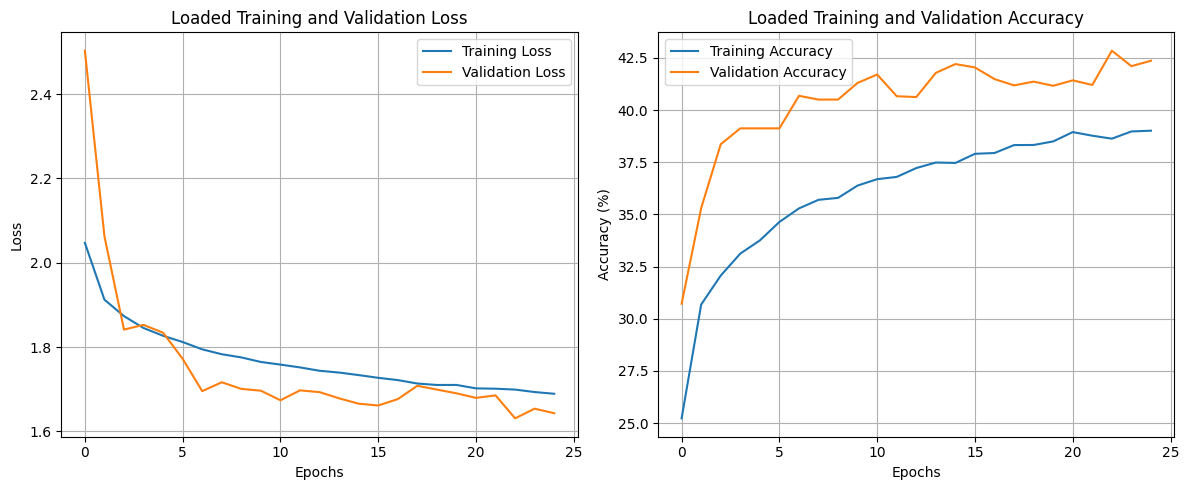

In [ ]:
import torch
import matplotlib.pyplot as plt

HISTORY_PATH = f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp{next_order}/mlp_history_{next_order}.pth" # Make sure this path is correct

loaded_history = torch.load(HISTORY_PATH)
loaded_train_losses = loaded_history['train_losses']
loaded_val_losses = loaded_history['val_losses']
loaded_train_accuracies = loaded_history['train_accuracies']
loaded_val_accuracies = loaded_history['val_accuracies']


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loaded_train_losses, label='Training Loss')
plt.plot(loaded_val_losses, label='Validation Loss')
plt.title('Loaded Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loaded_train_accuracies, label='Training Accuracy')
plt.plot(loaded_val_accuracies, label='Validation Accuracy')
plt.title('Loaded Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Plot Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
PATH_TO_SAVED_MODEL = f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp{next_order}/mlp_model_{next_order}.pth"
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(cifar10_classes)
loaded_model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes, dropout_p)
loaded_model.load_state_dict(torch.load(PATH_TO_SAVED_MODEL))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model.to(device)
loaded_model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = loaded_model(inputs)
        _, predicted_classes = torch.max(outputs, 1)

        all_predictions.extend(predicted_classes.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Confusion matrix saved to: /content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp20/confusion_matrix_20.png


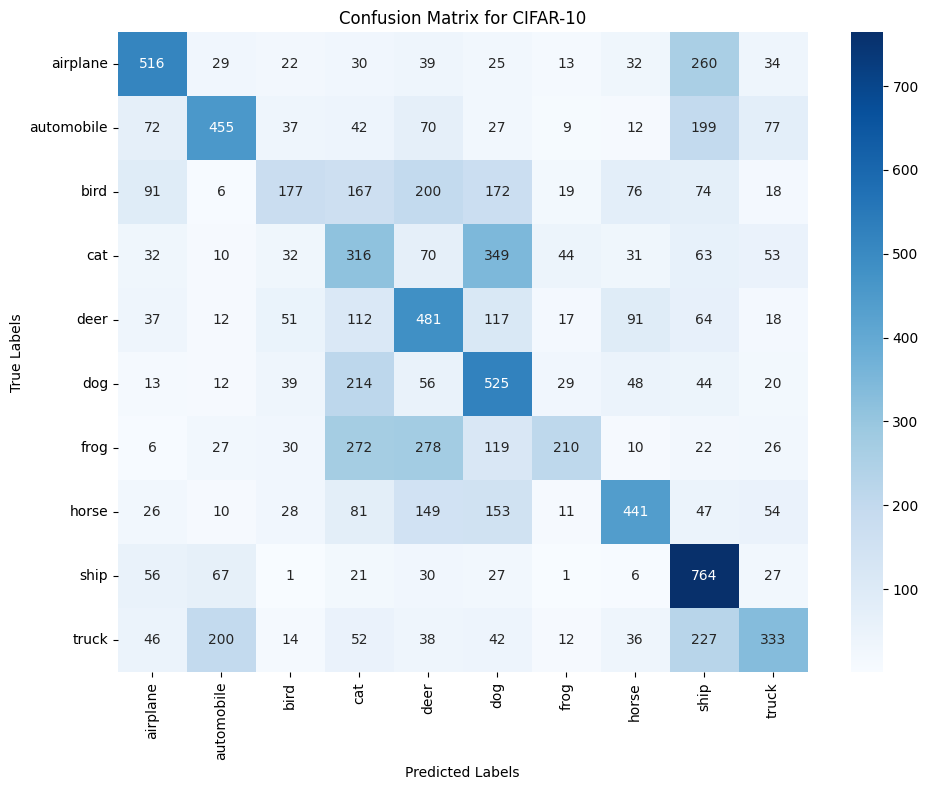

In [ ]:
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CIFAR-10')

plt.tight_layout()
cm_fname = f"confusion_matrix_{next_order}.png"
cm_save_path = os.path.join(f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp{next_order}", cm_fname)
plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrix saved to: {cm_save_path}")

plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("-" * 50)
print("Classification Report:")
print("-" * 50)
report_str = classification_report(all_labels, all_predictions, target_names=cifar10_classes, digits=2)
print(report_str)

report_filename = "classification_report.txt"
report_save_path = os.path.join(f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp{next_order}", report_filename)

with open(report_save_path, 'w', encoding='utf-8') as f:
    f.write("========= Classification Report =========\n")
    f.write(f"Generated on: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("=" * 40 + "\n\n")
    f.write(report_str)
print(f"Classification report saved to: {report_save_path}")

--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

    airplane       0.58      0.52      0.54      1000
  automobile       0.55      0.46      0.50      1000
        bird       0.41      0.18      0.25      1000
         cat       0.24      0.32      0.27      1000
        deer       0.34      0.48      0.40      1000
         dog       0.34      0.53      0.41      1000
        frog       0.58      0.21      0.31      1000
       horse       0.56      0.44      0.49      1000
        ship       0.43      0.76      0.55      1000
       truck       0.50      0.33      0.40      1000

    accuracy                           0.42     10000
   macro avg       0.45      0.42      0.41     10000
weighted avg       0.45      0.42      0.41     10000

Classification report saved to: /content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp20/classification_re

## Accuracies Performance

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:
def get_accuracy(model, data_loader, device):
    model.eval() # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    all_labels_list = []
    all_predictions_list = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted_classes = torch.max(outputs, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted_classes == labels).sum().item()

            all_predictions_list.extend(predicted_classes.cpu().numpy())
            all_labels_list.extend(labels.cpu().numpy())

    if total_samples == 0:
        return 0.0, [], []

    accuracy = 100. * correct_predictions / total_samples
    return accuracy, all_labels_list, all_predictions_list


In [ ]:
print("\n--- Calculating Final Accuracies ---")

final_train_accuracy, _, _ = get_accuracy(loaded_model, train_loader, DEVICE)
print(f"Final Accuracy on Training Set: {final_train_accuracy:.2f}%")

final_val_accuracy, val_labels, val_preds = get_accuracy(loaded_model, val_loader, DEVICE)
print(f"Final Accuracy on Validation Set: {final_val_accuracy:.2f}%")

final_test_accuracy, test_labels, test_preds = get_accuracy(loaded_model, test_loader, DEVICE)
print(f"Final Accuracy on Test Set: {final_test_accuracy:.2f}%")


--- Calculating Final Accuracies ---
Final Accuracy on Training Set: 42.08%
Final Accuracy on Validation Set: 42.36%
Final Accuracy on Test Set: 42.18%


In [ ]:
Acr = "Accuracies.txt"
Acr_path = os.path.join(f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp{next_order}", Acr)

with open(Acr_path, 'w', encoding='utf-8') as f:
    f.write("========= Accuracies Report =========\n")
    f.write("=" * 40 + "\n")
    f.write(f"- Final Accuracy on Training Set: {final_train_accuracy:.2f}%")
    f.write(f"\n- Final Accuracy on Validation Set: {final_val_accuracy:.2f}%")
    f.write(f"\n- Final Accuracy on Test Set: {final_test_accuracy:.2f}%")
print(f"Accuracies report saved to: {Acr_path}")

Accuracies report saved to: /content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp20/Accuracies.txt


## Test on image

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

In [15]:
def test_single_image(model, image, device, class_names, transform=None):
    """
    Test the model on a single image
    """
    model.eval()

    # If image is numpy array, convert to PIL or tensor
    if isinstance(image, np.ndarray):
        # Ensure image is in correct format (H, W, C) and uint8
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)

        # Apply transform if provided
        if transform:
            image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        else:
            # Convert to tensor and normalize
            image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            image_tensor = (image_tensor - 0.5) / 0.5  # Normalize to [-1, 1]
            image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

        # Get top 3 predictions
        top3_prob, top3_idx = torch.topk(probabilities, 3, dim=1)

    return predicted.item(), confidence.item(), top3_idx.squeeze().cpu().numpy(), top3_prob.squeeze().cpu().numpy()

In [4]:
def load_model_weights(model, weights_path, device):
    checkpoint = torch.load(weights_path, map_location=device)

    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    elif isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:

        model.load_state_dict(checkpoint)

    model.eval()
    return model

In [6]:
def visualize_predictions(test_data, predictions, true_labels, class_names, num_samples=16):
    """
    Visualize some test predictions
    """
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i in range(num_samples):
        row = i // 4
        col = i % 4

        # Display image
        axes[row, col].imshow(test_data[i])

        # Create title with prediction and true label
        pred_class = class_names[predictions[i]]
        true_class = class_names[true_labels[i]]

        if predictions[i] == true_labels[i]:
            color = 'green'
            title = f'✓ {pred_class}'
        else:
            color = 'red'
            title = f'✗ Pred: {pred_class}\nTrue: {true_class}'

        axes[row, col].set_title(title, color=color, fontsize=10)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
def load_and_test_single_image(test_batch_path, image_index, weights_path, model_class):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    (x_train, y_train), (x_test, y_test) = load_cifar10_data(test_batch_path)

    test_image = test_data[image_index]
    true_label = test_labels[image_index]

    print(f"Testing image at index {image_index}")
    print(f"True label: {class_names[true_label]}")
    print(f"Image shape: {test_image.shape}")

    # Data preprocessing transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Initialize and load model
    model = model_class(num_classes=10).to(device)
    model = load_model_weights(model, weights_path, device)

    # Test the image
    predicted_class, confidence, top3_classes, top3_probs = test_single_image(
        model, test_image, device, class_names, transform
    )

    # Display results
    print(f"\nPrediction Results:")
    print(f"Predicted class: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.3f}")
    print(f"Correct: {'Yes' if predicted_class == true_label else 'No'}")

    print(f"\nTop 3 predictions:")
    for i, (cls_idx, prob) in enumerate(zip(top3_classes, top3_probs)):
        print(f"{i+1}. {class_names[cls_idx]}: {prob:.3f}")

    # Visualize
    visualize_single_prediction(test_image, predicted_class, confidence,
                              top3_classes, top3_probs, class_names, true_label)

    return predicted_class, confidence, true_label


In [16]:
test_batch_path = '/content/drive/MyDrive/Hung/Assignment-2/cifar10_data/cifar-10-batches-py/test_batch'
weights_path = "/content/drive/MyDrive/Hung/Assignment-2/Experiments/MLP_run/Exp20"
image_index = 0

pred, conf, true = load_and_test_single_image(
    test_batch_path, image_index, weights_path, MLP
)

Using device: cpu


NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/Hung/Assignment-2/cifar10_data/cifar-10-batches-py/test_batch/data_batch_1'